In [1]:
import numpy as np
import utils as ut
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#function to generate perturbed matrices close to original matrix
def pert_matrix(mat_in,scale,n_rnd_param): 
    #mat_in: squared matrix to be perturbed (N x N)
    #scale: added perturbation between [0,scale]
    #n_rnd_param: number of perturbed matrix generated
    
    #dimension of the problem
    N = mat_in.shape[0]
    
    #eigendecomposition
    w,v = np.linalg.eig(mat_in)
    V   = v
    W   = np.diag(w)

    #generate perturbed matrices
    A_noise = []
    for rng in range(n_rnd_param):
        V_noise = scale*np.random.rand(N,N) + V
        A_noise.append(V_noise @ W @ np.linalg.inv(V_noise))
        
    return A_noise
 

In [2]:
## Input parameters
scale = 0.1     #scale for which original is perturbed
n_rnd_param = 2 #number of perturbed matrices to generate
x0 = np.transpose(np.matrix([[0.3,0.4,0.7]]))  #starting point (value from which forecast are made)
horizon = 4    #how many steps-ahead the forecast are made
n_samples = 1000  #how many forecast/trajectories are generated for EACH sampled VAR parameter

## Real values to estimate (array)
A = np.array([[.5,0,0],[.1,.1,.3],[0,.2,.3]]) #A = A1, VAR(p=1)
U = np.array([[2,0.11,0.09],[0.11,1.5,0.13],[0.09,0.13,1]])
print(U)
print(np.linalg.eigvals(A))
print(np.linalg.eigvals(U))

## Generate perturbed matrices
A_noise = pert_matrix(A,scale,n_rnd_param)
U_noise = pert_matrix(U,scale,n_rnd_param)

## Power curve
data_csv = pd.read_csv('data_power.csv') # Speed-PowerGeneration data.
xdata = data_csv['Wind speed (m/s)'].values
ydata = data_csv['Power (kW)'].values
fit_out = curve_fit(ut.PL5, xdata, ydata, maxfev=10000)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]

[[2.   0.11 0.09]
 [0.11 1.5  0.13]
 [0.09 0.13 1.  ]]
[ 0.46457513 -0.06457513  0.5       ]
[2.03611991 1.49939394 0.96448615]


In [3]:
#function that receives perturbed matrices for A,U and builds the resulting trajectories
def simulate_traj(A_noise,U_noise,offset,n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g):
    #A_noise: perturbed matrices for A
    #U_noise: perturbed matrices for U
    #cap_wind: installed capacity of each wind farm
    #cut_speed: cut out speed for wind turbines
    
    #sampl_traj: output vector with dimensions (n_samples,horizon,n_rnd_param)
    
    #list of generated trajectories for EACH sampled VAR paremeter
    sampl_traj = np.zeros((n_samples,horizon,n_rnd_param)) 
    for s_samp in range(n_rnd_param):
        A_s = A_noise[s_samp]
        U_s = U_noise[s_samp]
        traj_wind = ut.sim_wind(A_s,U_s,x0,horizon,n_samples)
        traj_wind = offset + traj_wind
        pow_wind = ut.power_curve(traj_wind, cap_wind, cut_speed, a, b, c, d, g)
        sampl_traj[:,:,s_samp] = np.sum(pow_wind,axis=0)
    
    return sampl_traj
    
def process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,flag_hist):
    #sampl_traj: sampled trajectoried from perturbed matrices (simulate_traj)
    #ql,qu: lower and upper quantile (1..100)
    #flag_hist: show comparison of histograms? (example case)
    
    #mean_mix: vector of means of total power generation for each horizon
    #ql_mix: lower quantile vector of total power generation for each horizon
    #qu_mix: lupper quantile vector of total power generation for each horizon
    
    #Mixing of all sampled VAR parameters trajectories
    mixed_traj = np.swapaxes(sampl_traj,1,2)
    mixed_traj = np.reshape(mixed_traj,(n_samples*n_rnd_param,horizon))
    
    #Example figures (only first horizon)
    if(flag_hist and (n_rnd_param<5)):
        print("Example figures for first horizon")
        f, axarr = plt.subplots(n_rnd_param+1, sharex=True)
        for n in range(n_rnd_param):
            axarr[n].hist(sampl_traj[:,0,n], 50, density=True, facecolor='green', alpha=0.75)
            axarr[n].set_title('VAR Param case'+str(n+1))
        axarr[n_rnd_param].hist(mixed_traj[:,0],50, density=True, facecolor='green', alpha=0.75)
        axarr[n_rnd_param].set_title('Mixed VAR Param case')
    elif(flag_hist and (n_rnd_param>=5)):
        print("ERROR: Examples figures cannot be shown for more than 4 sampled VAR parameters")
        
    #Computation of intervals and mean
    mean_mix = np.mean(mixed_traj,axis=0)
    ql_mix = np.percentile(mixed_traj,ql,axis=0)
    qu_mix = np.percentile(mixed_traj,qu,axis=0)
        
    return [mean_mix,ql_mix,qu_mix]
            

C:\Users\Samuel\Desktop\2018_01\IIC 3695 Intel Maquina\Tareas y Proyecto\Proyecto\Code\TAIM\utils.py:413: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


Example figures for first horizon
Resulting mean and quantiles
[array([3.67008416, 3.54743511, 3.50218984, 3.46217527]), array([2.51883072, 2.28781658, 2.25133125, 2.21743191]), array([4.88959205, 4.89605165, 4.88283983, 4.8311128 ])]


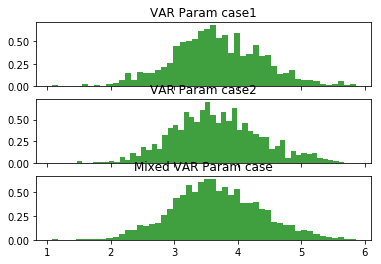

In [5]:
## Simulation of wind speed
cap_wind = 3 # wind plant capacity (eg. 3MW)
cut_speed = 20 # Speed where generator stop working for security.
offset = np.array([3,7,10])
offset = offset[:,None,None] #(3,) -> (3,1,1)
ql = 5
qu = 95


sampl_traj = simulate_traj(A_noise,U_noise,offset,n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
list_mix = process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,True)

print("Resulting mean and quantiles")
print(list_mix)    